In [1]:
from __future__ import division
import numpy as np
from matplotlib import pyplot as plt
import glob, operator, time, shutil, scipy, sys, sklearn
import pandas as pd
from sklearn.manifold import TSNE
from sklearn import preprocessing
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import metrics
from collections import Counter

pd.set_option('display.max_columns', 100)
plt.style.use('classic')

In [2]:
def new_fig(figsize=(8.9, 5)):
    plt.close()
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(111)
    for axis in ['top','bottom','left','right']:
        ax1.spines[axis].set_linewidth(3)    
    ax1.yaxis.grid(linestyle='--')
    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(18) 
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(18) 
    for line in ax1.get_xticklines() + ax1.get_yticklines():
        line.set_markersize(8)
    return ax1

In [3]:
df18 = pd.read_csv('data/composed/mira_top_10.csv')
# df18 = pd.read_csv('data/ANL-ALCF-AUTOPERF-MIRA_20180101_20181231.csv')
# df18.head(3)

/home/luckierdodge/anaconda3/envs/autoperf_tf/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (876) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
for k in df18.columns:
    if 'MPI' not in k:print(k)

run_date
disable_mpi_env
output_local_env
output_local_env_val
disable_mpi
output_local
zero_startCycle
zero_stopCycle
zero_elapsedCycles
zero_elapsedTime
zero_csJobId
zero_batchJobId
zero_userName
zero_execName
zero_numProcessesOnNode
zero_processHWThreads
zero_torusCoords[0]
zero_torusCoords[1]
zero_torusCoords[2]
zero_torusCoords[3]
zero_torusCoords[4]
zero_isTorus[0]
zero_isTorus[1]
zero_isTorus[2]
zero_isTorus[3]
zero_torusSize[0]
zero_torusSize[1]
zero_torusSize[2]
zero_torusSize[3]
zero_heapMaxUsed
zero_startCycle.1
zero_stopCycle.1
zero_elapsedCycles.1
zero_elapsedTime.1
zero_PEVT_LSU_COMMIT_LD_MISSES
zero_PEVT_LSU_COMMIT_CACHEABLE_LDS
zero_PEVT_L1P_BAS_MISS
zero_PEVT_INST_XU_ALL
zero_PEVT_INST_QFPU_ALL
zero_PEVT_INST_QFPU_FPGRP1
zero_PEVT_L2_HITS
zero_PEVT_L2_MISSES
zero_PEVT_L2_FETCH_LINE
zero_PEVT_L2_STORE_LINE
zero_PEVT_NW_USER_PP_SENT
zero_PEVT_NW_USER_PP_RECV
zero_disabled.3
zero_numRanks
zero_threadMode
zero_stdMpiTime
min_startCycle
min_stopCycle
min_elapsedCycles
min_e

# load store unit

In [5]:
# lsu_miss = 100. * ap_raw_1808.zero_PEVT_LSU_COMMIT_LD_MISSES / ap_raw_1808.zero_PEVT_LSU_COMMIT_CACHEABLE_LDS

In [6]:
gflops, gops, opf, opc = np.array([]), np.array([]), np.array([]), np.array([])
ram_fetch_bps, ram_store_bps, ram_fetch_bpop, ram_store_bpop = np.array([]), np.array([]), np.array([]), np.array([])
for fn in glob.glob('data/autoperf-*')[:]:
    data_df = pd.read_csv(fn)
    _gflops = 1e-9 * (data_df.av_PEVT_INST_QFPU_ALL / data_df.av_elapsedTime * data_df.av_numProcessesOnNode).values
    gflops = np.append(_gflops[~np.isnan(_gflops)], gflops)

    _ops = 1e-9 * ((data_df.av_PEVT_INST_XU_ALL + data_df.av_PEVT_INST_QFPU_ALL) / data_df.av_elapsedTime * data_df.av_numProcessesOnNode).values
    gops = np.append(_ops[~np.isnan(_ops)], gops)
    
    _opc = ((data_df.av_PEVT_INST_XU_ALL + data_df.av_PEVT_INST_QFPU_ALL) / data_df.av_elapsedCycles * data_df.av_numProcessesOnNode).values
    opc = np.append(_opc[~np.isnan(_opc)], opc)
    
    _opf  = data_df.av_PEVT_INST_XU_ALL / data_df.av_PEVT_INST_QFPU_ALL
    opf   = np.append(_opf[~np.isnan(_opf)], opf)
    
    _ram_fetch_bps = (data_df.av_PEVT_L2_FETCH_LINE * 128 / data_df.av_elapsedTime) * data_df.av_numProcessesOnNode
    ram_fetch_bps  = np.append(ram_fetch_bps, _ram_fetch_bps[~np.isnan(_ram_fetch_bps)])
    
    _ram_store_bps = (data_df.av_PEVT_L2_STORE_LINE * 128 / data_df.av_elapsedTime) * data_df.av_numProcessesOnNode
    ram_store_bps  = np.append(ram_store_bps, _ram_store_bps[~np.isnan(_ram_store_bps)])
    
    _ram_fetch_bpop = (data_df.av_PEVT_L2_FETCH_LINE * 128 / (data_df.av_PEVT_INST_QFPU_ALL + data_df.av_PEVT_INST_XU_ALL)) * data_df.av_numProcessesOnNode
    ram_fetch_bpop  = np.append(ram_fetch_bpop, _ram_fetch_bpop[~np.isnan(_ram_fetch_bpop)])
    
    _ram_store_bpop = (data_df.av_PEVT_L2_STORE_LINE * 128 / (data_df.av_PEVT_INST_QFPU_ALL + data_df.av_PEVT_INST_XU_ALL)) * data_df.av_numProcessesOnNode
    ram_store_bpop  = np.append(ram_store_bpop, _ram_store_bpop[~np.isnan(_ram_store_bpop)])
    

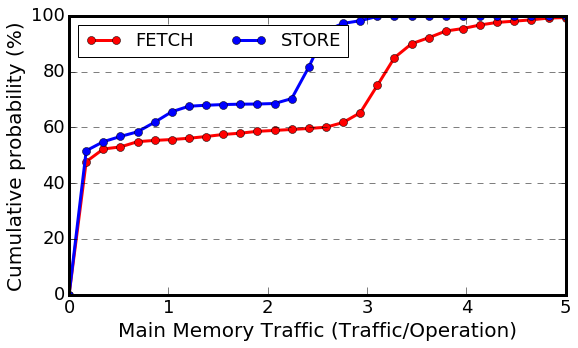

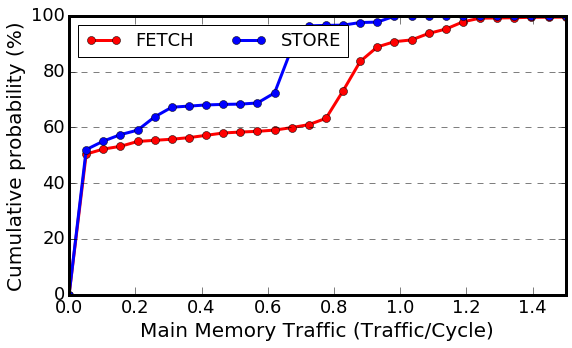

In [7]:
def plot_ram_rate(datas, labels, nbins=20, dmin=15, dmax=42, xlabel=None, ofn=None, is_xt = False):
    ax = new_fig()
    colors = ['r', 'b']
    for idx, data in enumerate(datas):
        bins = np.linspace(dmin, dmax, nbins)
        cnt  = [data[data<bf].shape[0] for bf in bins]
        norm = np.array(cnt) / data.shape[0] * 100
        plt.plot(bins, norm, '-o', linewidth=3, markersize=8, color=colors[idx], label=labels[idx])
#         plt.fill_between(bins, norm, color=colors[idx], alpha=.2)

    plt.ylabel('Cumulative probability (%)', fontsize=20)
    plt.xlabel(xlabel, fontsize=20)
    plt.xlim(left=dmin, right=dmax)
    if is_xt: plt.xticks(range(dmin, dmax, 2), [r'$2^{%d}$' % (p) for p in range(dmin, dmax, 2)], fontsize=20)
    plt.legend(ncol=2, loc=2, fontsize=18)
    
    if ofn is not None:
        plt.savefig('figure/'+ofn, bbox_inches='tight')
    plt.show()
        
    
# plot_ram_rate((np.log2(ram_fetch_bps), np.log2(ram_store_bps)), nbins=20, dmin=18, dmax=41, \
#               labels=('FETCH', 'STORE'), xlabel='Main Memory Traffic (Bytes/Second)', ofn='ram-bps.pdf', is_xt=True)

# plot_ram_rate((np.log2(ram_fetch_bpop), np.log2(ram_store_bpop)), nbins=30, dmin=0, dmax=11, \
#               labels=('FETCH', 'STORE'), xlabel='Main Memory Throughput (Bytes/Operation)', ofn='ram-bpop.pdf', is_xt=True)

plot_ram_rate((ram_fetch_bpop/128, ram_store_bpop/128), nbins=30, dmin=0, dmax=5, \
              labels=('FETCH', 'STORE'), xlabel='Main Memory Traffic (Traffic/Operation)', ofn='ram-tpop.pdf', is_xt=False)

plot_ram_rate((ram_fetch_bps/128/1.6e9, ram_store_bps/128/1.6e9), nbins=30, dmin=0, dmax=1.5, \
              labels=('FETCH', 'STORE'), xlabel='Main Memory Traffic (Traffic/Cycle)', ofn='ram-tpc.pdf', is_xt=False)

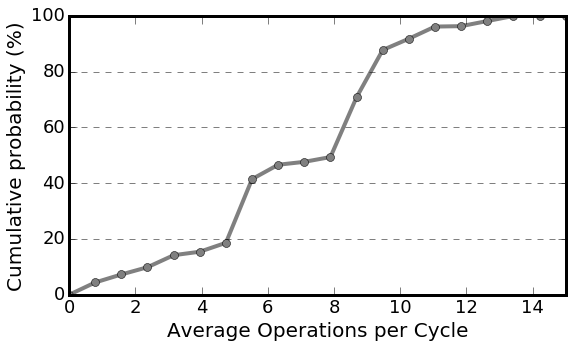

In [8]:
def plot_cdf_single(data, nbins=15, dmax=20, xlabel=None, ofn=None):    
    bins = np.linspace(0, dmax, 20)
    cnt  = [data[data<bf].shape[0] for bf in bins]
    norm = np.array(cnt) / data.shape[0] * 100
        
    ax = new_fig()
    plt.plot(bins, norm, '-o', linewidth=4, markersize=8, color='gray')
#     plt.fill_between(bins, norm, color='gold', alpha=.3)
    plt.ylabel('Cumulative probability (%)', fontsize=20)
    plt.xlabel(xlabel, fontsize=20)
    plt.xlim(left=0, right=bins[-1])
#     plt.xticks(range(0, 11), [r'%d' % (p) for p in range(0, 11)], fontsize=20)
    
    if ofn is not None:
        plt.savefig('figure/'+ofn, bbox_inches='tight')
    plt.show()
        
# plot_cdf_single(gflops, dmax=7, xlabel='Average GigaFLOPS per node', ofn='gflops.pdf')
# plot_cdf_single(gops, dmax=22, xlabel='Average GigaOPS per node', ofn='gops.pdf')

plot_cdf_single(opc, dmax=15, xlabel='Average Operations per Cycle', ofn='gopc.pdf')

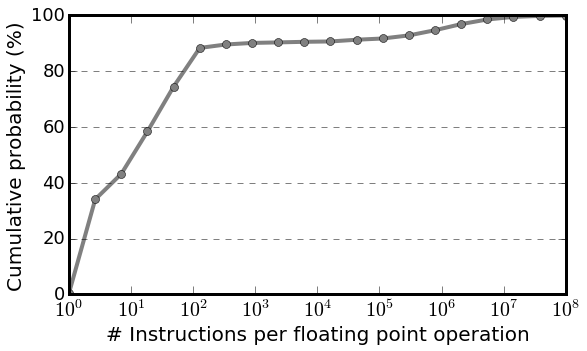

In [9]:
def plot_cdf_ipf(data, nbins=15, dmax=20, ofn=None):    
    bins = np.linspace(0, dmax, 20)
    cnt  = [data[data<bf].shape[0] for bf in bins]
    norm = np.array(cnt) / data.shape[0] * 100
        
    ax = new_fig()
    plt.plot(bins, norm, '-o', linewidth=4, markersize=8, color='gray')
#     plt.fill_between(bins, norm, color='gold', alpha=.3)
    plt.ylabel('Cumulative probability (%)', fontsize=20)
    plt.xlabel('# Instructions per floating point operation', fontsize=20)
    plt.xlim(left=0, right=bins[-1])
    plt.xticks(range(0, dmax+1), [r'$10^{%d}$' % (p) for p in range(0, dmax+1)], fontsize=20)
    
    if ofn is not None:
        plt.savefig('figure/'+ofn, bbox_inches='tight')
    plt.show()
    
plot_cdf_ipf(np.log10(opf), dmax=8, ofn='instruction-per-flop.pdf')

# log summary 

In [10]:
node_hours, n_tasks = 0, 0
for fn in glob.glob('data/autoperf-*')[:]:
    _pdf = pd.read_csv(fn)
    _nodes = (_pdf.zero_numRanks / _pdf.zero_numProcessesOnNode).values
    _mask  = ~np.isnan(_nodes)
    _nodes = _nodes[_mask]
    node_hours += (_pdf.av_elapsedTime[_mask] / 3600. * _nodes).sum()
    print('for logs in %s, %d log(s) are ignored because of nan' % (fn.split('/')[-1], _mask.shape[0] - _mask.sum()))
    n_tasks += _mask.sum()
    
print("core hours of {:,} tasks is {:,.2f} ".format(n_tasks, node_hours))

for logs in autoperf-2018-08.csv, 0 log(s) are ignored because of nan
for logs in autoperf-2019-02.csv, 0 log(s) are ignored because of nan
for logs in autoperf-2018-07.csv, 0 log(s) are ignored because of nan
for logs in autoperf-2018-10.csv, 0 log(s) are ignored because of nan
for logs in autoperf-2019-01.csv, 0 log(s) are ignored because of nan
for logs in autoperf-2018-05.csv, 0 log(s) are ignored because of nan
for logs in autoperf-2019-03.csv, 0 log(s) are ignored because of nan
for logs in autoperf-2018-06.csv, 2 log(s) are ignored because of nan
for logs in autoperf-2018-12.csv, 0 log(s) are ignored because of nan
for logs in autoperf-2018-04.csv, 1 log(s) are ignored because of nan
for logs in autoperf-2018-11.csv, 1 log(s) are ignored because of nan
for logs in autoperf-2018-09.csv, 1 log(s) are ignored because of nan
core hours of 388,187 tasks is 113,521,824.50 


In [11]:
_pdf = pd.read_csv('data/autoperf-2018-04.csv')

# visualize characters using T-SNE

In [12]:
def extrac_job_feature(fns):
    fname  = ('mpi_time', 'mpiio_time', 'OPS', 'FLOPS', 'ppn', 'ram_fetch', 'ram_store', 'exec_name')
    rvalue = np.zeros(shape=(0, len(fname)))
    exe_name, user_ame = [], []
    
    for fn in fns:
        _pdf  = pd.read_csv(fn)
        _cycles   = _pdf.av_elapsedCycles
        _eps_time = _pdf.av_elapsedTime
        _feat = np.c_[_pdf.av_stdMpiTime/_eps_time, _pdf.av_mpiIoTime/_eps_time, _pdf.av_PEVT_INST_XU_ALL/_cycles, \
                      _pdf.av_PEVT_INST_QFPU_ALL/_cycles, _pdf.av_numProcessesOnNode, \
                      _pdf.av_PEVT_L2_FETCH_LINE / _cycles, _pdf.av_PEVT_L2_STORE_LINE / _cycles]
        _nan_mask = ~np.isnan(_feat).any(axis=1)
        _feat = _feat[_nan_mask] # remove rows with nan
        _exec_name = _pdf.zero_execName.values[_nan_mask]
        _feat  = np.append(_feat, np.expand_dims(_exec_name, 1), axis=1)
        
        exe_name += _pdf.zero_execName.values[_nan_mask].tolist()
        user_ame += _pdf.zero_userName.values[_nan_mask].tolist()
        rvalue = np.append(rvalue, _feat, axis=0)
    return pd.DataFrame(rvalue, columns=fname), np.array(exe_name), np.array(user_ame)

task_feature, exe_name, user_ame = extrac_job_feature(glob.glob('data/autoperf-*')[:])
task_feature.to_pickle("data/task-fingerprint.pkl")
task_feature.shape, exe_name.shape, user_ame.shape

((388187, 8), (388187,), (388187,))

In [13]:
pca_obj = sklearn.decomposition.PCA(n_components=2)
pca_obj.fit(task_feature.values[:, :-1])
print('explained variance ratio (first two components): %s'
      % str(pca_obj.explained_variance_ratio_))
pca_red = pca_obj.transform(task_feature.values[:, :-1])

explained variance ratio (first two components): [0.96988032 0.02823579]


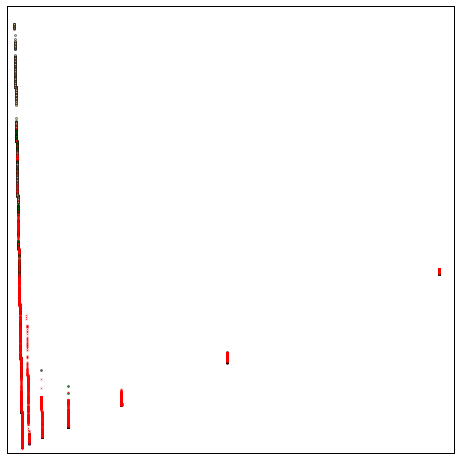

In [14]:
def pca_vis_by_group(x_emb, exe_idn, topn=10, ofn=None):
    idn_unique, idn_count = np.unique(exe_idn, return_counts=True)
    top_idn = idn_unique[np.argsort(idn_count)[-topn:]]
    plt.figure(figsize=(8, 8))
    colors = ('g', 'b', 'gold', 'yellow', 'tan', 'cyan', 'magenta', 'black', 'orange', 'darkgreen')
    _other_grp = np.zeros(exe_idn.shape[0], dtype=np.bool)
    for _idx, _idn in enumerate(top_idn):
        _emb_grp = x_emb[exe_idn == _idn]
        plt.plot(_emb_grp[:, 0], _emb_grp[:, 1], 'o', alpha=.8, color=colors[_idx], markersize=2, label = _idn)
        _other_grp |= (exe_idn == _idn)
        
    _uncat = x_emb[~_other_grp]
    plt.plot(_uncat[:, 0], _uncat[:, 1], 'x', alpha=.8, color='r', markersize=1.5, label = 'Uncat')
    
    plt.xlim(left=x_emb[:, 0].min()*1.05, right=x_emb[:, 0].max()*1.05)
    plt.ylim(bottom=x_emb[:, 1].min()*1.05, top=x_emb[:, 1].max()*1.05)
    plt.xticks([])
    plt.yticks([])
#     plt.legend(ncol=4, loc=2, fancybox=False, framealpha=0.5)
    if ofn is not None:
        plt.savefig('figure/' + ofn, bbox_inches='tight', quality=99, dpi=300)
    plt.show()
    plt.close()
    
pca_vis_by_group(pca_red, task_feature.exec_name.values, )

In [15]:
task_feature.shape

(388187, 8)

In [16]:
tsne_obj = TSNE(n_components=2, random_state=2019)
X_embedded = tsne_obj.fit_transform(preprocessing.scale(task_feature.values[:45000, :-1]))
X_embedded.shape, tsne_obj.kl_divergence_, tsne_obj.n_iter_

((45000, 2), 1.2600547075271606, 999)

In [17]:
task_feature.head()

,mpi_time,mpiio_time,OPS,FLOPS,ppn,ram_fetch,ram_store,exec_name
0,0.762992,0,0.312527,2.44369e-09,16,6.81996e-06,1.12775e-05,IOR
1,0.355963,0,0.283802,0.0469493,8,0.000384402,0.000561457,nek5000
2,0.354683,0,0.291264,0.0474852,8,0.00040004,0.000578622,nek5000
3,0.76016,0,0.311084,2.3876e-09,16,7.26012e-06,1.14426e-05,IOR
4,0.765964,0,0.312871,2.45821e-09,16,6.89325e-06,1.13356e-05,IOR


converge-2.4-mira-cat is marked by g and x
aims.180111.scalapack.mpi.x is marked by b and o
vasp_gam is marked by gold and >
lmp_mpi_7b is marked by yellow and <
ks_spectrum_hisq is marked by tan and s
converge is marked by cyan and v
qlua is marked by magenta and H
mcfm_omp is marked by black and D
IOR is marked by orange and 3
nek5000 is marked by darkgreen and 1


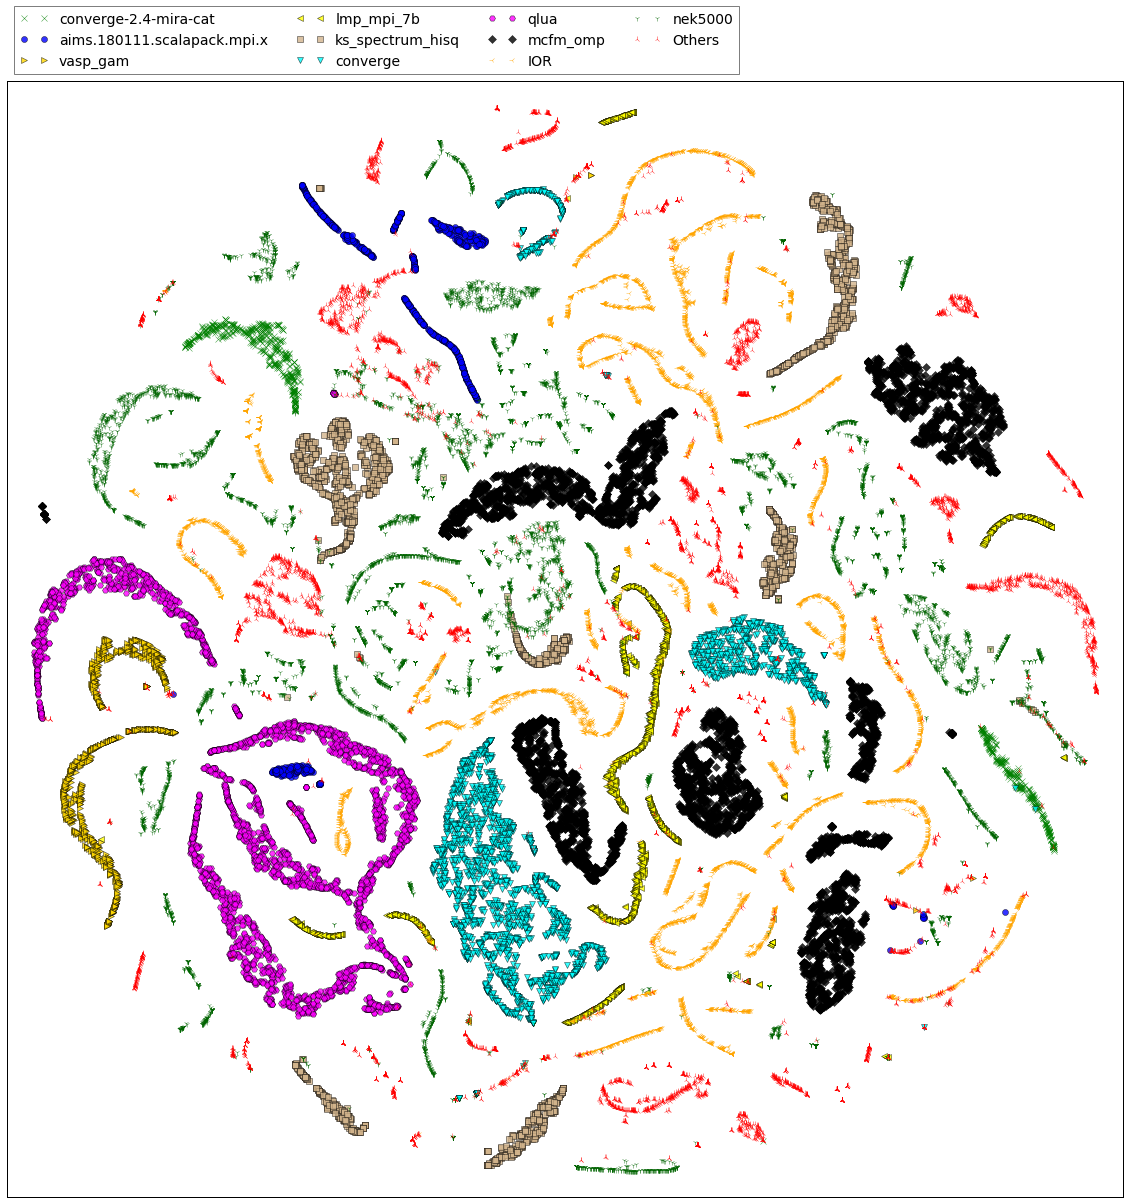

In [18]:
def t_sne_vis_by_group(x_emb, exe_idn, topn=3, ofn=None):
    idn_unique, idn_count = np.unique(exe_idn, return_counts=True)
    top_idn = idn_unique[np.argsort(idn_count)[-topn:]]
    plt.figure(figsize=(20, 20))
    colors = ('g', 'b', 'gold', 'yellow', 'tan', 'cyan', 'magenta', 'black', 'orange', 'darkgreen')
    markers= ('x', 'o', '>', '<', 's', 'v', 'H', 'D', '3', '1', '2')
    _other_grp = np.zeros(exe_idn.shape[0], dtype=np.bool)
    for _idx, _idn in enumerate(top_idn):
        _emb_grp = x_emb[exe_idn == _idn]
        plt.plot(_emb_grp[:, 0], _emb_grp[:, 1], markers[_idx], alpha=.8, color=colors[_idx], markersize=6, label = _idn[:])
        _other_grp |= (exe_idn == _idn)
        print("%s is marked by %s and %s" % (_idn, colors[_idx], markers[_idx]))
    _uncat = x_emb[~_other_grp]
    plt.plot(_uncat[:, 0], _uncat[:, 1], markers[-1], alpha=.8, color='r', markersize=6, label = 'Others')
    
    plt.xlim(left=X_embedded[:, 0].min()*1.05, right=X_embedded[:, 0].max()*1.05)
    plt.ylim(bottom=X_embedded[:, 1].min()*1.05, top=X_embedded[:, 1].max()*1.05)
    plt.xticks([])
    plt.yticks([])
    plt.legend(bbox_to_anchor=(0., 1.0, 1., .102), ncol=4, loc=3, fancybox=False, framealpha=0.5, fontsize=14)
    if ofn is not None:
        plt.savefig('figure/' + ofn, bbox_inches='tight', quality=99, dpi=300)
    plt.show()
    plt.close()
#     print(top_idn)
# t_sne_vis_by_group(X_embedded, user_ame, topn=10, ofn='tsne-username.png')
t_sne_vis_by_group(X_embedded, task_feature.values[:45000, -1], topn=10, ofn='tsne-exename.png')

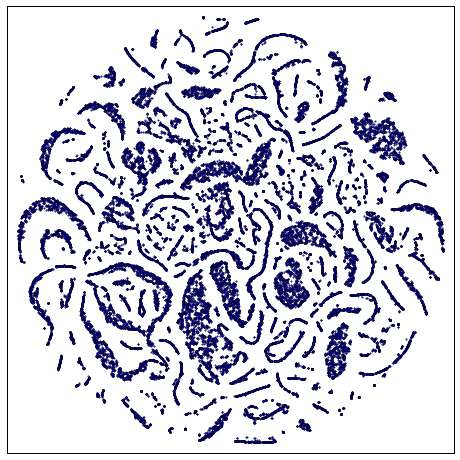

In [19]:
# ax = new_fig(figsize=(8, 8))
plt.figure(figsize=(8, 8))
plt.plot(X_embedded[:, 0], X_embedded[:, 1], 'o', alpha=.8, color='b', markersize=1.5)
# plt.axis('off')
# plt.xlabel('t-SNE Dimension 1', fontsize=18)
# plt.ylabel('t-SNE Dimension 2', fontsize=18)
plt.xlim(left=X_embedded[:, 0].min()*1.05, right=X_embedded[:, 0].max()*1.05)
plt.ylim(bottom=X_embedded[:, 1].min()*1.05, top=X_embedded[:, 1].max()*1.05)
plt.xticks([])
plt.yticks([])
plt.savefig('figure/task-t-sne.png', bbox_inches='tight', quality=99, dpi=300)
plt.show()
plt.close()

In [20]:
pdf_test = pd.read_csv('data/autoperf-2018-08.csv')

In [21]:
topn = 10
idn_unique, idn_count = np.unique(exe_name, return_counts=True)
idn_unique[np.argsort(idn_count)[-topn:]]

array(['xmfdn-menj_BGQ-lan', 'vasp_gam', 'qlua', 'converge', 'mcfm_omp',
       'ks_spectrum_hisq', 'IOR', 'nek5000', 'lmp_mpi_7b',
       'aims.180111.scalapack.mpi.x'], dtype='<U71')

In [22]:
exe_names_rank = pd.read_csv('data/autoperf-2018-08.csv').zero_execName.value_counts()

In [23]:
exe_names = {}
for fn in glob.glob('data/autoperf-*')[:]:
    _pdf = pd.read_csv(fn)
    exe_rank = _pdf.zero_execName.value_counts()
    for exe in exe_rank.keys():
        if not isinstance(exe, str): continue
        if exe_names.get(exe) is None:
            exe_names[exe] = exe_rank[exe]
        else:
            exe_names[exe] += exe_rank[exe]
#         if 'hacc' in exe.lower(): print(exe)

In [24]:
names = np.array(list(exe_names.keys()))
vals  = np.array(list(exe_names.values()))
n_jobs= np.sum(vals)
with open('exe-name-rank.txt', 'w') as fd:
    fd.write('name,freq\n')
    for idx in np.argsort(vals)[::-1]:
        fd.write('%s,%.4f\n' % (names[idx], 100.*vals[idx]/n_jobs))

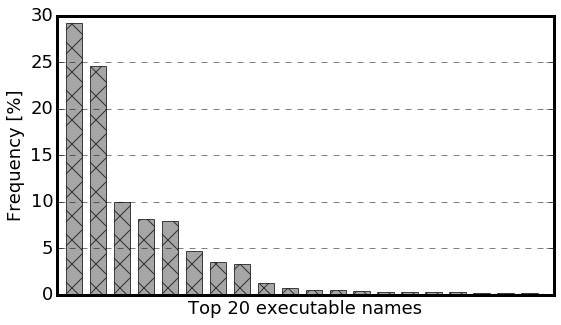

In [25]:
def plot_exe_name_grp(topN, ofn=None):
    _pdf = pd.read_csv('exe-name-rank.txt')
    ax = new_fig()
    width = .7
    plt.bar(range(topN), _pdf.freq[:topN], align='center', 
            width=width, color='gray', alpha=.7, hatch='x')
    
    plt.xlim(left=-width, right=topN)
    plt.xlabel('Top %d executable names' % topN, fontsize=18)
    plt.xticks([], [])
    plt.ylabel('Frequency [%]', fontsize=18)
    if ofn is not None:
        plt.savefig('figure/' + ofn, bbox_inch='tight')
        
plot_exe_name_grp(20, ofn='exename-freq.pdf')

In [26]:
# get user to exetable name map
username2exename = {}
for fn in glob.glob('data/autoperf-*')[:]:
    _pdf = pd.read_csv(fn)
    for u, e in _pdf[['zero_userName', 'zero_execName']].values:
        if username2exename.get(u) is None:
            username2exename[u] = set()
        username2exename[u].add(e)
        
with open('username2exename.txt', 'w') as rd:
    for u in username2exename.keys():
        rd.write("{}:{}\n".format(u, username2exename[u]))

In [27]:
# compute number of tasks using the difference between max and min of CS ID
min_cs_jid, max_cs_jid, total_jids = np.inf, 0, 0
for fn in glob.glob('data/autoperf-*')[1:]:
    _pdf = pd.read_csv(fn)
    total_jids += _pdf.shape[0]
    min_cs_jid = min(min_cs_jid, _pdf.zero_csJobId.min())
    max_cs_jid = max(max_cs_jid, _pdf.zero_csJobId.max())

print("There should be at least {:,.0f} tasks, but only {:,} are logged, {:.2f}%%".format(\
      max_cs_jid-min_cs_jid, total_jids, 100.*total_jids/(max_cs_jid-min_cs_jid)))

There should be at least 546,594 tasks, but only 383,382 are logged, 70.14%%


# try to classify application by name

In [28]:
task_feature = pd.read_pickle("data/task-fingerprint.pkl")
task_feature.head(3)

,mpi_time,mpiio_time,OPS,FLOPS,ppn,ram_fetch,ram_store,exec_name
0,0.762992,0,0.312527,2.44369e-09,16,6.81996e-06,1.12775e-05,IOR
1,0.355963,0,0.283802,0.0469493,8,0.000384402,0.000561457,nek5000
2,0.354683,0,0.291264,0.0474852,8,0.00040004,0.000578622,nek5000


In [29]:
(task_feature.FLOPS.values * task_feature.ppn.values).max(), task_feature.FLOPS.max()

(9.664402069580845, 9.664402069580845)

In [30]:
flops_arg_max = np.argsort(task_feature.FLOPS.values)[::-1]
ops_arg_max = np.argsort(task_feature.OPS.values)[::-1]
task_feature.iloc[ops_arg_max[:10]]

,mpi_time,mpiio_time,OPS,FLOPS,ppn,ram_fetch,ram_store,exec_name
257332,0.0028195,0,13.7684,0.2673,1,1.12843e-05,1.44931e-05,mcfm_omp
257330,0.00279408,0,13.7652,0.269575,1,1.12842e-05,1.44951e-05,mcfm_omp
257324,0.0026388,0,13.7485,0.268296,1,1.12824e-05,1.44846e-05,mcfm_omp
257325,0.00292157,0,13.7447,0.269032,1,1.1274e-05,1.44853e-05,mcfm_omp
257327,0.00285022,0,13.7376,0.28283,1,1.12772e-05,1.44833e-05,mcfm_omp
257326,0.00333747,0,13.7184,0.282878,1,1.12871e-05,1.44949e-05,mcfm_omp
23929,0.00304646,0,13.6923,0.270306,1,1.16248e-05,1.65135e-05,mcfm_omp
23935,0.0169177,0,13.6923,0.266304,1,1.17298e-05,1.65564e-05,mcfm_omp
24033,0.0167871,0,13.6911,0.266502,1,1.17213e-05,1.65372e-05,mcfm_omp
24027,0.0166753,0,13.6902,0.266418,1,1.16992e-05,1.65863e-05,mcfm_omp


In [31]:
def data_preprocess(feat_df, topn=10):
    tops_labels = feat_df.exec_name.value_counts()[:topn].keys()
    print("top {} executables are: {}".format(topn, tops_labels))
    exec_name2id = {}
    for i, x in enumerate(tops_labels):
        exec_name2id[x] = i
    exec_name2id['others'] = topn
    
    ret_df = feat_df.copy(deep=True) # make a copy
    enc = np.zeros(feat_df.shape[0], dtype=np.int8)
    for i, x in enumerate(feat_df.exec_name.values):
        _enc = exec_name2id.get(x)
        if _enc is None: _enc = exec_name2id['others']
        enc[i] = _enc
        
    ret_df['exec_name'] = enc
    X, Y = ret_df[ret_df.columns[:-1]].astype(np.float), ret_df[ret_df.columns[-1:]].astype(np.int8)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=2019)
    return X_train, X_test, y_train, y_test 

X_train, X_test, y_train, y_test = data_preprocess(task_feature, topn=20)

top 20 executables are: Index(['aims.180111.scalapack.mpi.x', 'lmp_mpi_7b', 'nek5000', 'IOR',
       'ks_spectrum_hisq', 'mcfm_omp', 'converge', 'qlua', 'vasp_gam',
       'xmfdn-menj_BGQ-lan', 'qlua-bkend', 'fs_verify.iomap', 'fdl3di.exe',
       'aims.071914_7.scalapack.mpi.x', 'goma', 'converge-2.4-mira-cat',
       'rxmd', 'pibis', 'bench', 'vof.exe'],
      dtype='object')


In [32]:
task_feature.FLOPS.max(), task_feature.OPS.max()

(9.664402069580845, 13.768436459588642)

In [33]:
for i in range(y_train.exec_name.unique().shape[0]):
    print("{}: {:,.2f}".format(i, 100.*(y_train.exec_name==i).sum()/y_train.shape[0]))

0: 29.19
1: 24.55
2: 9.94
3: 8.19
4: 7.98
5: 4.64
6: 3.46
7: 3.37
8: 1.26
9: 0.68
10: 0.53
11: 0.49
12: 0.37
13: 0.34
14: 0.34
15: 0.32
16: 0.30
17: 0.21
18: 0.20
19: 0.16
20: 3.48


In [34]:
xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=2019, max_depth=10)
xgb_model.fit(X_train, y_train.values.ravel())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='multi:softprob',
              random_state=2019, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

In [35]:
y_pred = xgb_model.predict(X_test)
y_true = y_test.values.ravel()

In [36]:
metrics.accuracy_score(y_true, y_pred), metrics.f1_score(y_true, y_pred, average='macro')

(0.9968572090986373, 0.9926311648639538)

In [37]:
# percentage of mistake in "other" category, they are "other" but the classifier failed to catch
(y_true[y_true != y_pred]==20).sum() / y_true[y_true != y_pred].shape[0]

0.45901639344262296

In [38]:
diff = y_pred - y_true
"{:,} out of {:,}, acc: {:.3f}%".format(diff[diff==0].shape[0], diff.shape[0], diff[diff==0].shape[0] / diff.shape[0])

'116,091 out of 116,457, acc: 0.997%'

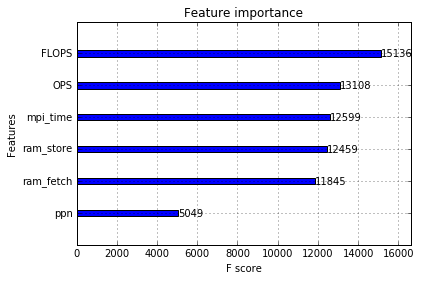

In [39]:
xgb.plot_importance(xgb_model, importance_type='weight')

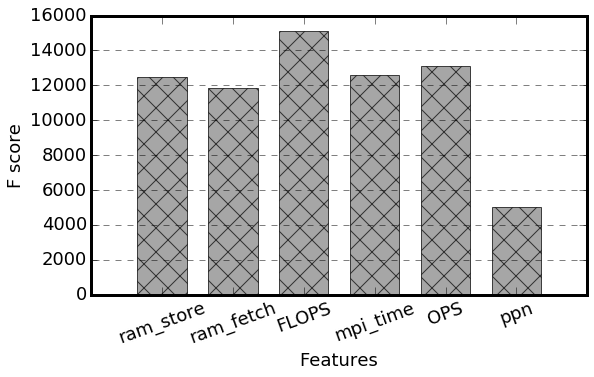

In [40]:
def plot_feat_importance(imp, ofn=None):
    ax = new_fig()
    width = .7
    plt.bar(range(len(imp)), imp.values(), align='center', 
            width=width, color='gray', alpha=.7, hatch='x')
    
    plt.xlabel('Features', fontsize=18)
    plt.xticks(range(len(imp)), imp.keys(), rotation=20)
    plt.ylabel('F score', fontsize=18)
    if ofn is not None:
        plt.savefig('figure/' + ofn, bbox_inches='tight')
        
plot_feat_importance(xgb_model.get_booster().get_score(importance_type="weight"), )

In [41]:
xgb_model.get_booster().get_score(importance_type="gain"), 

({'ram_store': 158.3077612956104,
  'ram_fetch': 50.23827661489101,
  'FLOPS': 82.93484588954776,
  'mpi_time': 111.27176636814026,
  'OPS': 50.59470573058476,
  'ppn': 59.8697796520719},)

In [42]:
exec_names = ('aims.180111.scalapack.mpi.x', 'lmp_mpi_7b', 'IOR', 'nek5000',
              'ks_spectrum_hisq', 'aims.160328_3.scalapack.mpi.x', 'mcfm_omp', 'qlua',
              'converge', 'vasp_gam', 'xmfdn-menj_BGQ-lan', 'project_dyn',
              'qlua-bkend', 'distress', 'fs_verify.iomap', 'dns', 'fdl3di.exe',
              'aims.071914_7.scalapack.mpi.x', 'goma', 'converge-2.4-mira-cat')

In [43]:
def job_dist(fn, key, topn=20, ofn=None):
    ntasks = pd.read_csv(fn)[key].value_counts().values
    ntask_cnt = np.array(Counter(ntasks).most_common(topn))
    print("%.2f%% jobs are covered by top %d" % (100.*ntask_cnt[:, 1].sum()/ntasks.shape[0], topn))
    ax = new_fig()
    plt.bar(range(ntask_cnt.shape[0]), 100.*ntask_cnt[:, 1]/ntasks.shape[0], \
            width=.6, align='center', color='gray', hatch='x')
    plt.ylabel('Percentage of Jobs', fontsize=22)
    plt.xlabel('Number of tasks per job', fontsize=22)
    plt.xticks(range(ntask_cnt.shape[0]), ['%d' % x for x in ntask_cnt[:,0]])
    plt.xlim(left=-.5)
    plt.ylim(top=99)
    if ofn is not None:
        plt.savefig('figure/' + ofn, bbox_inches='tight')
    plt.show()
    plt.close()
    
for fn in sorted(glob.glob('data/ANL-ALCF-AUTOPERF-MIRA_*'))[1:2]:
# for fn in sorted(glob.glob('datasets/autoperf/autoperf-*'))[:]:
    print(fn)
    job_dist(fn, key='PROC_BATCHJOBID', topn=10)
#     job_dist(fn, key='zero_batchJobId', topn=10, ofn=fn.split('/')[-1][:-4]+'.pdf')

In [44]:
_pdf = pd.read_csv('data/ANL-ALCF-AUTOPERF-MIRA_20160101_20161231.csv')
topn = 10
ntasks = _pdf.PROC_BATCHJOBID.value_counts().values
ntask_cnt = np.array(Counter(ntasks).most_common(topn))

print(ntasks.shape, _pdf.shape, _pdf.PROC_BATCHJOBID.unique().shape, ntasks.sum())

_pdf[_pdf.PROC_BATCHJOBID == 770000].PROC_CSJOBID

FileNotFoundError: [Errno 2] File b'data/ANL-ALCF-AUTOPERF-MIRA_20160101_20161231.csv' does not exist: b'data/ANL-ALCF-AUTOPERF-MIRA_20160101_20161231.csv'

In [ ]:
_pdf_raw = pd.read_csv('data/autoperf-2018-08.csv')
_pdf_raw.zero_csJobId.unique().shape, _pdf_raw.shape